In [56]:
import duckdb
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


path = "/home/etienne/projects/obsq/work/dev/data/data.duckdb"
target = ['spatial_match', 'expert_match_score', 'community_score', 'data_qualiy_score', 'scientific_score']
pd.set_option('display.float_format', lambda x: '%.5f' % x)


In [57]:
table = 'combined'
schema = 'features'
con = duckdb.connect(path)
df = con.execute(f"""SELECT* FROM {schema}.{table}""" ).df()
#df = df.drop(columns= 'geom')
con.close()

In [58]:
df.head()

,gbifID,spatial_match,expert_match_score,community_score,data_qualiy_score,scientific_score,observer_pca0,observer_pca1,histo_taxon_ttl_obs_count,histo_taxon_obs_month_density,...,pheno_repro_month_density,pheno_sex_month_density,taxo_freq,taxo_confusability_index,gee_pca0,gee_pca1,gee_pca2,gee_pca3,spatial_cluster,range
0,3079585653,0.00000,0.75000,0.38000,0.20000,0.15772,70.16294,121.37913,6,0.00000,...,0.00000,0.00000,0.49800,0,-184.05447,-75.87245,-51.85384,-36.21936,2,1
1,3079604030,0.66000,0.75000,0.34000,0.50000,0.02440,-30.90239,539.55238,6,0.00000,...,0.00000,0.00000,0.77000,10,-140.91754,2.52086,-12.96020,1.06626,5,1
2,3079611217,0.33000,0.75000,0.38000,0.50000,0.04830,-30.90239,539.55238,6,0.00000,...,0.00000,0.00000,1.98100,13,-52.96314,-15.26065,-11.81705,8.30630,5,1
3,3079659298,0.33000,0.75000,0.34000,0.50000,0.04100,-30.90239,539.55238,6,0.00000,...,0.00000,0.00000,3.10500,24,-137.59948,0.16487,-21.62956,-3.38988,5,1
4,3079677289,0.00000,0.75000,0.34000,0.20000,0.17835,-30.90239,539.55238,6,0.00000,...,0.00000,0.00000,0.56300,0,-125.03013,1.68823,-26.59190,-5.16974,5,1


In [59]:
df.set_index('gbifID', inplace=True)

In [60]:
X = df.drop(columns=target)
y_multi = df[target].values
X.head()

,observer_pca0,observer_pca1,histo_taxon_ttl_obs_count,histo_taxon_obs_month_density,cmva_id_count,cmva_id_agree_rate,cmva_id_time,cmva_expert_id,tempo_day,tempo_month,...,pheno_repro_month_density,pheno_sex_month_density,taxo_freq,taxo_confusability_index,gee_pca0,gee_pca1,gee_pca2,gee_pca3,spatial_cluster,range
gbifID,,,,,,,,,,,,,,,,,,,,,
3079585653,70.16294,121.37913,6,0.00000,2,1.00000,0,0,4,4,...,0.00000,0.00000,0.49800,0,-184.05447,-75.87245,-51.85384,-36.21936,2,1
3079604030,-30.90239,539.55238,6,0.00000,1,1.00000,0,0,7,4,...,0.00000,0.00000,0.77000,10,-140.91754,2.52086,-12.96020,1.06626,5,1
3079611217,-30.90239,539.55238,6,0.00000,2,1.00000,0,0,8,4,...,0.00000,0.00000,1.98100,13,-52.96314,-15.26065,-11.81705,8.30630,5,1
3079659298,-30.90239,539.55238,6,0.00000,1,1.00000,0,0,2,4,...,0.00000,0.00000,3.10500,24,-137.59948,0.16487,-21.62956,-3.38988,5,1
3079677289,-30.90239,539.55238,6,0.00000,1,1.00000,0,0,2,4,...,0.00000,0.00000,0.56300,0,-125.03013,1.68823,-26.59190,-5.16974,5,1


In [61]:
base_model = RandomForestRegressor(n_estimators=10, random_state=42)
multi_model = MultiOutputRegressor(base_model)


In [62]:
X_train, X_test, y_multi_train, y_multi_test = train_test_split(X, y_multi, test_size=0.25, random_state=0)
n_samples = len(y_multi_train)
n_pos = y_multi_train.sum()
n_neg = n_samples - n_pos
scale_pos_weight = n_neg / n_pos

In [63]:
multi_model.fit(X_train, y_multi_train)

,estimator estimator: estimator objectAn estimator object implementing :term:`fit` and :term:`predict`.,RandomForestR...ndom_state=42)
,"n_jobs n_jobs: int or None, optional (default=None)The number of jobs to run in parallel.:meth:`fit`, :meth:`predict` and :meth:`partial_fit` (if supportedby the passed estimator) will be parallelized for each target.When individual estimators are fast to train or predict,using ``n_jobs > 1`` can result in slower performance dueto the parallelism overhead.``None`` means `1` unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all available processes / threads.See :term:`Glossary ` for more details... versionchanged:: 0.20 `n_jobs` default changed from `1` to `None`.",None
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",10
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least 

In [64]:
predictions = multi_model.predict(X_test)

In [65]:
# Each column is one quality dimension
id_acc_pred = predictions[:, 0]
data_qual_pred = predictions[:, 1]
community_pred = predictions[:, 2]
scientific_pred = predictions[:, 3]

In [66]:
multi_model.score(X_test, y_multi_test)

0.8304005386237104

In [67]:
overall_quality_pred = (
    0.4 * id_acc_pred +
    0.3 * data_qual_pred +
    0.2 * community_pred +
    0.1 * scientific_pred
)

In [68]:
# Calculate evaluation metrics

mae = mean_absolute_error(y_multi_test, predictions)
mse = mean_squared_error(y_multi_test, predictions)
r_squared = r2_score(y_multi_test, predictions)
rmse = np.sqrt(mse)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r_squared)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.03899518792989832
Mean Squared Error (MSE): 0.013232283470552737
R-squared (R²): 0.8304005386237104
Root Mean Squared Error (RMSE): 0.11503166290440531


In [69]:
df_predictions = pd.DataFrame(predictions)
df_predictions

,0,1,2,3,4
0,0.31900,0.00000,0.34000,0.20000,0.12376
1,0.14704,0.00000,0.34000,0.50000,0.01157
2,0.00637,0.00000,0.34000,0.45000,0.01157
3,0.08525,0.50000,0.38000,0.50000,0.04226
4,0.00000,0.00000,0.38000,0.20000,0.04930
...,...,...,...,...,...
8959,0.00000,0.50000,0.34000,0.65000,0.00931
8960,0.45740,0.65000,0.34000,0.20000,0.03949
8961,0.18975,0.00000,0.34000,0.20000,0.01811
8962,0.44944,0.00000,0.34000,0.35000,0.05609


In [70]:
df_test = pd.DataFrame(y_multi_test)
df_test

,0,1,2,3,4
0,0.33000,0.00000,0.34000,0.20000,0.12376
1,0.00000,0.00000,0.34000,0.50000,0.01157
2,0.00000,0.00000,0.34000,0.45000,0.01157
3,0.00000,0.50000,0.38000,0.50000,0.04226
4,0.00000,0.00000,0.38000,0.20000,0.04930
...,...,...,...,...,...
8959,0.00000,0.50000,0.34000,0.65000,0.00931
8960,1.00000,0.75000,0.34000,0.20000,0.03949
8961,0.00000,0.00000,0.34000,0.20000,0.01811
8962,0.33000,0.00000,0.34000,0.35000,0.05609


In [71]:
combined_df = pd.concat([df_test.assign(source='test'), df_predictions.assign(source='pred')])
pivot_df = combined_df.pivot(columns= 'source')
pivot_df

0               1               2               3          \
source    pred    test    pred    test    pred    test    pred    test   
0      0.31900 0.33000 0.00000 0.00000 0.34000 0.34000 0.20000 0.20000   
1      0.14704 0.00000 0.00000 0.00000 0.34000 0.34000 0.50000 0.50000   
2      0.00637 0.00000 0.00000 0.00000 0.34000 0.34000 0.45000 0.45000   
3      0.08525 0.00000 0.50000 0.50000 0.38000 0.38000 0.50000 0.50000   
4      0.00000 0.00000 0.00000 0.00000 0.38000 0.38000 0.20000 0.20000   
...        ...     ...     ...     ...     ...     ...     ...     ...   
8959   0.00000 0.00000 0.50000 0.50000 0.34000 0.34000 0.65000 0.65000   
8960   0.45740 1.00000 0.65000 0.75000 0.34000 0.34000 0.20000 0.20000   
8961   0.18975 0.00000 0.00000 0.00000 0.34000 0.34000 0.20000 0.20000   
8962   0.44944 0.33000 0.00000 0.00000 0.34000 0.34000 0.35000 0.35000   
8963   0.33537 0.00000 0.00000 0.00000 0.34000 0.34000 0.20000 0.20000   

             4          
source    pred    test  
0      0.12376 0.12376  
1      0.01157 0.01157  
2      0.01157 0.01157  
3      0.04226 0.04226  
4      0.04930 0.04930  
...        ...     ...  
8959   0.00931 0.00931  
8960   0.03949 0.03949  
8961   0.01811 0.01811  
8962   0.05609 0.05609  
8963   0.05886 0.05886  

[8964 rows x 10 columns]

<Axes: xlabel='4', ylabel='source'>

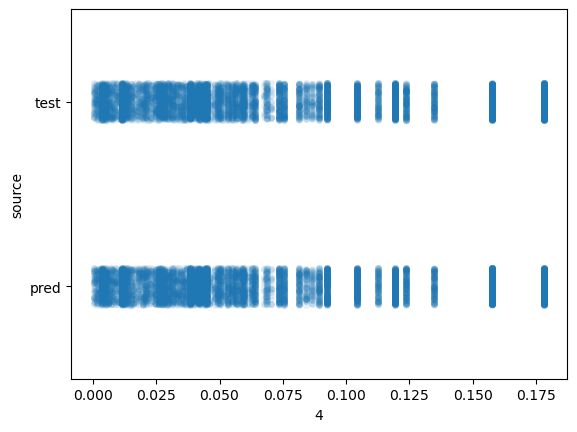

In [77]:
sns.stripplot(combined_df, x = 4, y='source',alpha =0.1)